In [1]:
import os
import gc
import pandas as pd
pd.set_option('display.max_colwidth', 100)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
import string
from nltk.corpus import words
from nltk.tokenize import word_tokenize
import mlflow
import mlflow.sklearn
import mlflow.keras
from mlflow.models.signature import infer_signature
from sklearn.model_selection import GridSearchCV
import re
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import auc as auc_score_func
from sklearn.metrics import make_scorer, classification_report, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, accuracy_score, average_precision_score, roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import spacy
from spacy.tokens import Doc
from spacy.language import Language
import gensim
import tensorflow as tf
import tensorflow_hub as hub
from keras.models import Sequential, Model
from keras.layers import Embedding, LSTM, Dense, Dropout, Flatten, Input, Conv1D, MaxPooling1D, GlobalMaxPooling1D, SpatialDropout1D
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import regularizers
from keras.callbacks import EarlyStopping
from transformers import BertTokenizer, TFBertModel
from tqdm import tqdm
from gensim.models import Word2Vec
from gensim.test.utils import common_texts
from gensim.models import KeyedVectors
import gensim.downloader as api
import fasttext.util
from numba import cuda
from transformers import BertTokenizer, TFBertForSequenceClassification
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from keras.optimizers import Adam
from transformers import PreTrainedTokenizerFast

In [2]:
print(tf.config.get_visible_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
def load_data():
    column_names = ["target", "ids", "date", "flag", "user", "text"]
    df = pd.read_csv("sentiment140/training.1600000.processed.noemoticon.csv", names=column_names, encoding='latin1')
    display(df)
    return df

df = load_data()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Thi..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School to...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you a..."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best feeling ever
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interviews! â« http://blip.fm/~8bmta
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me for details
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! Tupac Amaru Shakur


## Analyse des données

In [16]:
df.info()
df.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


target          2
ids       1598315
date       774363
flag            1
user       659775
text      1581466
dtype: int64

target    0.0
ids       0.0
date      0.0
flag      0.0
user      0.0
text      0.0
dtype: float64
Nombres de tweets dupliqués :  18534
col = target -> duplicated = 1599998
col = ids -> duplicated = 1685
col = date -> duplicated = 825637
col = flag -> duplicated = 1599999
col = user -> duplicated = 940225
col = text -> duplicated = 18534


0          False
1          False
2          False
3          False
4          False
           ...  
1599995    False
1599996    False
1599997    False
1599998    False
1599999    False
Name: text, Length: 1600000, dtype: bool


,target,ids
count,1.600000e+06,1.600000e+06
mean,2.000000e+00,1.998818e+09
std,2.000001e+00,1.935761e+08
min,0.000000e+00,1.467810e+09
25%,0.000000e+00,1.956916e+09
50%,2.000000e+00,2.002102e+09
75%,4.000000e+00,2.177059e+09
max,4.000000e+00,2.329206e+09


,date,flag,user,text
count,1600000,1600000,1600000,1600000
unique,774363,1,659775,1581466
top,Mon Jun 15 12:53:14 PDT 2009,NO_QUERY,lost_dog,isPlayer Has Died! Sorry
freq,20,1600000,549,210


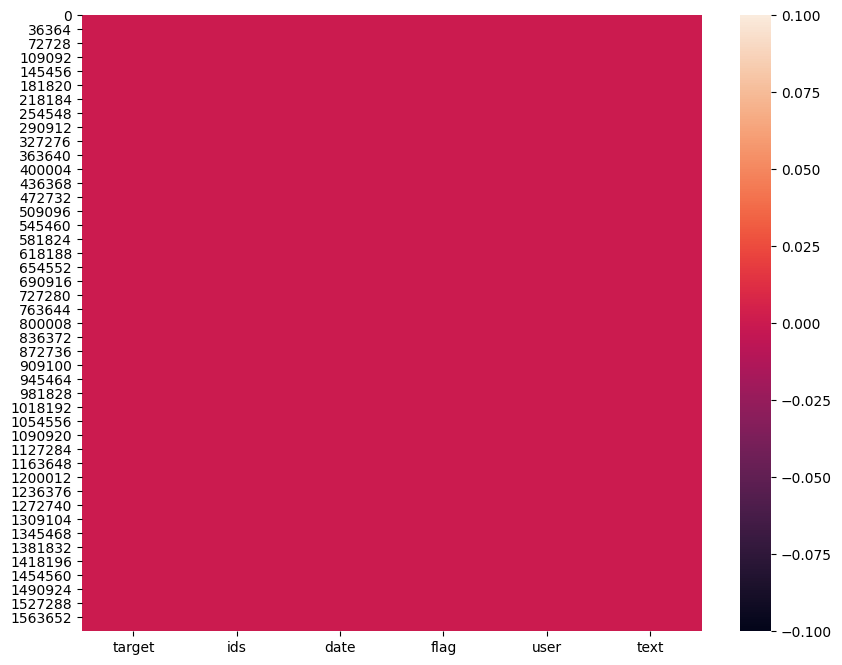

In [5]:
def analyse_data(data):
    """
    Analyse un DataFrame en affichant le pourcentage de valeurs manquantes, une heatmap des valeurs manquantes,
    le nombre de doublons pour l'ensemble du DataFrame et par colonne. Affiche également des statistiques
    descriptives pour les colonnes numériques et non numériques.

    Args:
        data (pandas.DataFrame): DataFrame à analyser.

    Returns:
        None. Cette fonction affiche directement les informations et les graphiques.
    """
    print(data.isna().mean().sort_values())
    plt.figure(figsize=(10, 8))
    sns.heatmap(data.isna())
    print("Nombres de tweets dupliqués : ", data.text.duplicated().sum())
    for col in data.columns:
        n = data[col].duplicated().sum()
        print(f"col = {col} -> duplicated = {n}")
    print("\n")
    print(data.text.duplicated(keep="first"))
    idx = data.text.duplicated(keep="first")
    data.loc[idx, :].sort_values("text").head(10)
    display(data.describe(include=np.number))
    display(data.describe(include=object))

analyse_data(df)

C:\Users\aurel\miniconda3\envs\tensorflow\lib\site-packages\seaborn\axisgrid.py:64: UserWarning: The figure layout has changed to tight
  self.fig.tight_layout(*args, **kwargs)


Text(0.5, 1.0, 'Distribution du nombre de caractères des tweets')

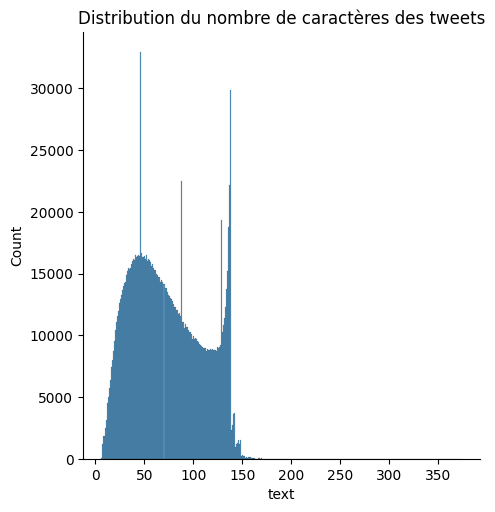

In [18]:
tmp = df.text.str.len()
sns.displot(tmp)
plt.title("Distribution du nombre de caractères des tweets")

In [19]:
tmp.sort_values(ascending=False)

1295281    374
1484882    369
380539     359
1582941    359
650945     348
          ... 
1071086      6
1229947      6
4233         6
310554       6
1050599      6
Name: text, Length: 1600000, dtype: int64

In [3]:
def drop_columns(df):
    df = df[['target', 'text']]
    return df

def drop_text_duplicate(df):
    df = df.drop_duplicates(subset="text")
    return df

def filter_tweet(df):
    df['text'] = df['text'].str.strip()
    filtered_df = df[df['text'].str.match('^(@\w+\s*)+$')]
    df = df.drop(filtered_df.index, axis= 0)
    display(filtered_df.head(20))
    print(f"Nombre de tweets non informatif supprimés : {filtered_df.shape[0]}")
    return df

df = drop_columns(df)
df = drop_text_duplicate(df)
df = filter_tweet(df)

,target,text
208,0,@mandayyy
249,0,@mandayyy
398,0,@danadearmond
430,0,@anistorm
1011,0,@citizensheep
1014,0,@GirlsGoneChild
1231,0,@thecoolestout
1421,0,@marlonjenglish
1486,0,@oishiieats
1641,0,@thisisguan


Nombre de tweets non informatif supprimés : 2552


In [4]:
def create_sample(df, n_sample):
    negative_tweets = df[df.iloc[:, 0] == 0]
    negative_tweets = negative_tweets.sample(n = n_sample, random_state=0)
    positive_tweets = df[df.iloc[:, 0] == 4]
    positive_tweets.loc[:,'target'] = positive_tweets['target'].replace({4:1})
    positive_tweets = positive_tweets.sample(n = n_sample, random_state=0)
    df_sample = pd.concat([negative_tweets, positive_tweets], ignore_index=True)
    return df_sample
df_sample = create_sample(df, 750_000)

In [10]:
df_sample.target.value_counts(normalize=True)

target
0    0.5
1    0.5
Name: proportion, dtype: float64

In [5]:
def display_tokens_info(tokens):
    """display info about corpus"""
    print(f"nb tokens {len(tokens)}, nb tokens uniques {len(set(tokens))}")
    print(tokens[:30])
eng_words = nltk.corpus.words.words()
display_tokens_info(eng_words)

nb tokens 236736, nb tokens uniques 235892
['A', 'a', 'aa', 'aal', 'aalii', 'aam', 'Aani', 'aardvark', 'aardwolf', 'Aaron', 'Aaronic', 'Aaronical', 'Aaronite', 'Aaronitic', 'Aaru', 'Ab', 'aba', 'Ababdeh', 'Ababua', 'abac', 'abaca', 'abacate', 'abacay', 'abacinate', 'abacination', 'abaciscus', 'abacist', 'aback', 'abactinal', 'abactinally']


In [12]:
ps = nltk.PorterStemmer()
eng_words_stem = [ps.stem(i) for i in eng_words]
display_tokens_info(eng_words_stem)

nb tokens 236736, nb tokens uniques 178311
['a', 'a', 'aa', 'aal', 'aalii', 'aam', 'aani', 'aardvark', 'aardwolf', 'aaron', 'aaron', 'aaron', 'aaronit', 'aaronit', 'aaru', 'ab', 'aba', 'ababdeh', 'ababua', 'abac', 'abaca', 'abac', 'abacay', 'abacin', 'abacin', 'abaciscu', 'abacist', 'aback', 'abactin', 'abactin']


In [13]:
lm = nltk.WordNetLemmatizer()
eng_words_lem = [lm.lemmatize(i) for i in eng_words]
display_tokens_info(eng_words_lem)

nb tokens 236736, nb tokens uniques 235068
['A', 'a', 'aa', 'aal', 'aalii', 'aam', 'Aani', 'aardvark', 'aardwolf', 'Aaron', 'Aaronic', 'Aaronical', 'Aaronite', 'Aaronitic', 'Aaru', 'Ab', 'aba', 'Ababdeh', 'Ababua', 'abac', 'abaca', 'abacate', 'abacay', 'abacinate', 'abacination', 'abaciscus', 'abacist', 'aback', 'abactinal', 'abactinally']


In [14]:
"""
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('words')
"""

"\nnltk.download('omw-1.4')\nnltk.download('wordnet')\nnltk.download('stopwords')\nnltk.download('words')\n"

### Preprocessing

In [6]:
def expand_contractions(text: str) -> str:
    
    flags = re.IGNORECASE | re.MULTILINE
    
    text = re.sub(r'`', "'", text, flags = flags)
    
    ## starts / ends with '
    text = re.sub(
        r"(\s|^)'(aight|cause)(\s|$)",
        '\g<1>\g<2>\g<3>',
        text, flags = flags
    )
    
    text = re.sub(
        r"(\s|^)'t(was|is)(\s|$)", r'\g<1>it \g<2>\g<3>',
        text,
        flags = flags
    )
    
    text = re.sub(
        r"(\s|^)ol'(\s|$)",
        '\g<1>old\g<2>',
        text, flags = flags
    )
    
    ## expand words without '
    text = re.sub(r"\b(aight)\b", 'alright', text, flags = flags)
    text = re.sub(r'\bcause\b', 'because', text, flags = flags)
    text = re.sub(r'\b(finna|gonna)\b', 'going to', text, flags = flags)
    text = re.sub(r'\bgimme\b', 'give me', text, flags = flags)
    text = re.sub(r"\bgive'n\b", 'given', text, flags = flags)
    text = re.sub(r"\bhowdy\b", 'how do you do', text, flags = flags)
    text = re.sub(r"\bgotta\b", 'got to', text, flags = flags)
    text = re.sub(r"\binnit\b", 'is it not', text, flags = flags)
    text = re.sub(r"\b(can)(not)\b", r'\g<1> \g<2>', text, flags = flags)
    text = re.sub(r"\bwanna\b", 'want to', text, flags = flags)
    text = re.sub(r"\bmethinks\b", 'me thinks', text, flags = flags)
    
    ## one offs,
    text = re.sub(r"\bo'er\b", r'over', text, flags = flags)
    text = re.sub(r"\bne'er\b", r'never', text, flags = flags)
    text = re.sub(r"\bo'?clock\b", 'of the clock', text, flags = flags)
    text = re.sub(r"\bma'am\b", 'madam', text, flags = flags)
    text = re.sub(r"\bgiv'n\b", 'given', text, flags = flags)
    text = re.sub(r"\be'er\b", 'ever', text, flags = flags)
    text = re.sub(r"\bd'ye\b", 'do you', text, flags = flags)
    text = re.sub(r"\be'er\b", 'ever', text, flags = flags)
    text = re.sub(r"\bd'ye\b", 'do you', text, flags = flags)
    text = re.sub(r"\bg'?day\b", 'good day', text, flags = flags)
    text = re.sub(r"\b(ain|amn)'?t\b", 'am not', text, flags = flags)
    text = re.sub(r"\b(are|can)'?t\b", r'\g<1> not', text, flags = flags)
    text = re.sub(r"\b(let)'?s\b", r'\g<1> us', text, flags = flags)
    
    ## major expansions involving smaller,
    text = re.sub(r"\by'all'dn't've'd\b", 'you all would not have had', text, flags = flags)
    text = re.sub(r"\by'all're\b", 'you all are', text, flags = flags)
    text = re.sub(r"\by'all'd've\b", 'you all would have', text, flags = flags)
    text = re.sub(r"(\s)y'all(\s)", r'\g<1>you all\g<2>', text, flags = flags)
    
    ## minor,
    text = re.sub(r"\b(won)'?t\b", 'will not', text, flags = flags)
    text = re.sub(r"\bhe'd\b", 'he had', text, flags = flags)

    ## major,
    text = re.sub(r"\b(I|we|who)'?d'?ve\b", r'\g<1> would have', text, flags = flags)
    text = re.sub(r"\b(could|would|must|should|would)n'?t'?ve\b", r'\g<1> not have', text, flags = flags)
    text = re.sub(r"\b(he)'?dn'?t'?ve'?d\b", r'\g<1> would not have had', text, flags = flags)
    text = re.sub(r"\b(daren|daresn|dasn)'?t", 'dare not', text, flags = flags)
    text = re.sub(r"\b(he|how|i|it|she|that|there|these|they|we|what|where|which|who|you)'?ll\b", r'\g<1> will', text, flags = flags)
    text = re.sub(r"\b(everybody|everyone|he|how|it|she|somebody|someone|something|that|there|this|what|when|where|which|who|why)'?s\b", r'\g<1> is', text, flags = flags)
    text = re.sub(r"\b(I)'?m'a\b", r'\g<1> am about to', text, flags = flags)
    text = re.sub(r"\b(I)'?m'o\b", r'\g<1> am going to', text, flags = flags)
    text = re.sub(r"\b(I)'?m\b", r'\g<1> am', text, flags = flags)
    text = re.sub(r"\bshan't\b", 'shall not', text, flags = flags)
    text = re.sub(r"\b(are|could|did|does|do|go|had|has|have|is|may|might|must|need|ought|shall|should|was|were|would)n'?t\b", r'\g<1> not', text, flags = flags)
    text = re.sub(r"\b(could|had|he|i|may|might|must|should|these|they|those|to|we|what|where|which|who|would|you)'?ve\b", r'\g<1> have', text, flags = flags)
    text = re.sub(r"\b(how|so|that|there|these|they|those|we|what|where|which|who|why|you)'?re\b", r'\g<1> are', text, flags = flags)
    text = re.sub(r"\b(I|it|she|that|there|they|we|which|you)'?d\b", r'\g<1> had', text, flags = flags)
    text = re.sub(r"\b(how|what|where|who|why)'?d\b", r'\g<1> did', text, flags = flags)

    
    return text

In [7]:
class ExpandContractionsComponent:
    name = "expand_contractions"

    def __init__(self, nlp: Language):
        self.nlp = nlp

    def __call__(self, doc: Doc) -> Doc:
        text = doc.text
        text = expand_contractions(text)
        return self.nlp.make_doc(text)

@Language.factory('expand_contractions')
def create_expand_contractions(nlp, name):
    return ExpandContractionsComponent(nlp)

In [8]:
def clean_docs(texts, lemmatize=False, stem=False, rejoin=False):
    if lemmatize and stem:
        raise ValueError("Un seul transformateur peut être appliqué.")
        
    def clean_text(text):
        text = re.sub(r'@[A-Za-z0-9_-]{1,15}\b'," ", text)
        text = re.sub(r'https?://[A-Za-z0-9./]+'," ", text)
        text = re.sub(r'&amp;|&quot;', " ", text)
        return text
    texts = [clean_text(text) for text in texts]
    
    nlp = spacy.load('en_core_web_lg')
    docs = nlp.pipe(texts, disable=['parser', 'ner', 'textcat', 'tok2vec'], batch_size=10_000)
    nlp.add_pipe('expand_contractions', before='tagger')
    stemmer = nltk.PorterStemmer()
    
    docs_cleaned = []
    for doc in docs:
        doc = [token for token in doc if token.is_alpha]
        if lemmatize:
            tokens = [tok.lemma_.strip() for tok in doc]
        elif stem:
            tokens = [stemmer.stem(tok.text.strip()) for tok in doc]
        else:
            tokens = [tok.text.strip() for tok in doc]
        
        if rejoin:
            tokens = ' '.join(tokens)
        docs_cleaned.append(tokens)
    
    return docs_cleaned

class SpacyTextCleaner(BaseEstimator, TransformerMixin):
    def __init__(self, lemmatize=False, stem=False, rejoin=False):
        self.lemmatize = lemmatize
        self.stem = stem
        self.rejoin = rejoin

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return clean_docs(X, self.lemmatize, self.stem, self.rejoin)

In [9]:
%%time
df_sample['clean_text_lem'] = tqdm(clean_docs(df_sample['text'], lemmatize=True))

100%|███████████████████████████████████████████████████████████████████| 1500000/1500000 [00:00<00:00, 4503537.93it/s]


CPU times: total: 6min 33s
Wall time: 10min 54s


In [14]:
df_sample

,target,text,clean_text_lem
0,0,[-O] sometimes i wish that i could change time to save the ones i love. http://tinyurl.com/n6dv9q,"[sometimes, i, wish, that, i, could, change, time, to, save, the, ones, i, love]"
1,0,@BabyLuu not if it's yours. ahahaha jk. missss you,"[not, if, it, is, yours, ahahaha, jk, missss, you]"
2,0,"probably missed out on presale, hopefully ney is prepped for when they actually go on sale. sad ...","[probably, missed, out, on, presale, hopefully, ney, is, prepped, for, when, they, actually, go,..."
3,0,@nicolegaudioso u. R. A. Freak. @jackalltimelow is on mtv now. He doesn't have time 4 us,"[freak, is, on, mtv, now, he, does, not, have, time, us]"
4,0,I'm alive! At bff's house. Checked out our new house this afternoon and I'm not happy,"[i, am, alive, at, bff, house, checked, out, our, new, house, this, afternoon, and, i, am, not, ..."
...,...,...,...
1499995,1,@BrianViloria ohhh so P.Diddy finally got a ticket... this morning on Ryan Seacrest radio stat...,"[ohhh, so, finally, got, a, ticket, this, morning, on, ryan, seacrest, radio, station, he, was, ..."
1499996,1,strawberries for breakfast. it's really summer now,"[strawberries, for, breakfast, it, is, really, summer, now]"
1499997,1,"@sirrenarae: baby, you have got to get on this where ARE you???","[baby, you, have, got, to, get, on, this, where, are, you]"
1499998,1,so many plans. working on the summer list.,"[so, many, plans, working, on, the, summer, list]"


In [20]:
empty_tweets = df_sample.loc[df_sample["clean_text_lem"] == ""]
display(empty_tweets)
print(f"Nombres de tweets vides après Lemmatisation : {empty_tweets.shape[0]}")

,target,text,clean_text_lem


Nombres de tweets vides après Lemmatisation : 0


In [21]:
# empty_tweets['target'].value_counts()
# df_sample.drop(empty_tweets.index, axis=0, inplace=True)
# print(df_sample.target.value_counts(normalize=True))

On remarque qu'en supprimant les stopwords, certains tweets se retrouvent vides après lemmatisation

In [9]:
def train_valid_test_split(X, y, train_size=0.8, valid_size=0.1, test_size=0.1, random_state=0):
    if train_size + valid_size + test_size != 1.0:
        raise ValueError("Les proportions ne s'additionnent pas à 1.0")

    X_train, X_temp, y_train, y_temp = train_test_split(X,
                                                        y,
                                                        stratify=y,
                                                        test_size=1-train_size,
                                                        random_state=random_state)

    relative_test_size = test_size / (valid_size + test_size)

    X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp,
                                                        stratify=y_temp,
                                                        test_size=relative_test_size,
                                                        random_state=random_state)

    return X_train, X_valid, X_test, y_train, y_valid, y_test

In [10]:
def calcul_metrics(y_valid, y_valid_pred, y_valid_proba, recover = False):
    print(classification_report(y_valid, y_valid_pred))
    accuracy = accuracy_score(y_valid, y_valid_pred)
    print("Accuracy score :", accuracy)
    precision = precision_score(y_valid, y_valid_pred)
    print("Precision Score :", precision)
    recall = recall_score(y_valid, y_valid_pred)
    print("Recall Score :", recall)
    f1 = f1_score(y_valid, y_valid_pred)
    print("F1 Score :", f1)
    roc_auc = roc_auc_score(y_valid, y_valid_proba)
    print("AUC :" , roc_auc)
    aucpr_score = average_precision_score(y_valid, y_valid_proba)
    print("Average-precision score : ", aucpr_score, "\n")
    
    if recover:
        return accuracy, precision, recall, f1, roc_auc, aucpr_score

## Regression Logistique

### BoW - TFIDF

In [24]:
%%time
mlflow.set_tracking_uri('file://' + os.path.abspath('mlruns'))
experiment_name = "Regression Logistique"
mlflow.set_experiment(experiment_name)
with mlflow.start_run(run_name="TFIDF 500K sample"):
    params = {"penalty": "l2", "C": 1.0, "random_state": 0}
    pipeline = Pipeline([
        ('clean_text', SpacyTextCleaner(stem=True, rejoin=True)),
        ('vect', TfidfVectorizer()),
        ('clf', LogisticRegression(**params))
    ])
    X_train, X_valid, X_test, y_train, y_valid, y_test = train_valid_test_split(df_sample['text'] ,df_sample['target'])
    pipeline.fit(X_train, y_train)
    y_valid_pred = pipeline.predict(X_valid)
    y_valid_proba = pipeline.predict_proba(X_valid)[:, 1]
    accuracy, precision, recall, f1, score_auc, aucpr_score = calcul_metrics(y_valid, y_valid_pred, y_valid_proba, recover=True)
    mlflow.log_param("preprocessing", "Stemming et TF-IDF")
    mlflow.log_params(params)
    mlflow.log_metrics({
    "accuracy_score": accuracy,
    "precision_score": precision,
    "recall_score": recall,
    "f1_score": f1,
    "auc": score_auc,
    "average_precision_score":aucpr_score,
    })
    signature = infer_signature(X_valid, y_valid_pred)
    mlflow.sklearn.log_model(
        sk_model=pipeline.named_steps['clf'],
        artifact_path="tf-idf & stem",
        signature=signature,
        registered_model_name="tf-idf & stem",
    )

2023/07/09 21:57:50 INFO mlflow.tracking.fluent: Experiment with name 'Regression Logistique' does not exist. Creating a new experiment.
C:\Users\aurel\miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.80      0.78      0.79     75000
           1       0.79      0.80      0.79     75000

    accuracy                           0.79    150000
   macro avg       0.79      0.79      0.79    150000
weighted avg       0.79      0.79      0.79    150000

Accuracy score : 0.7922133333333333
Precision Score : 0.7850379773176569
Recall Score : 0.8048
F1 Score : 0.7947961655957022
AUC : 0.8717412984888889
Average-precision score :  0.8725936541059651 



C:\Users\aurel\miniconda3\envs\tensorflow\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Successfully registered model 'tf-idf & stem'.
2023/07/09 22:12:01 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: tf-idf & stem, version 1


CPU times: total: 11min 51s
Wall time: 14min 11s


Created version '1' of model 'tf-idf & stem'.


In [25]:
%%time
with mlflow.start_run(run_name="TFIDF 500K sample"):
    pipeline.set_params(clean_text__stem=False, clean_text__lemmatize=True)
    pipeline.fit(X_train, y_train)
    y_valid_pred = pipeline.predict(X_valid)
    y_valid_proba = pipeline.predict_proba(X_valid)[:, 1]
    accuracy, precision, recall, f1, score_auc, aucpr_score = calcul_metrics(y_valid, y_valid_pred,y_valid_proba, recover=True)
    mlflow.log_param("preprocessing", "Lemmatisation et TF-IDF")
    mlflow.log_params(params)
    mlflow.log_metrics({
    "accuracy_score": accuracy,
    "precision_score": precision,
    "recall_score": recall,
    "f1_score": f1,
    "auc": score_auc,
    "precision_recall_score": aucpr_score,
    })
    signature = infer_signature(X_valid, y_valid_pred)
    mlflow.sklearn.log_model(
        sk_model=pipeline.named_steps['clf'],
        artifact_path="tf-idf & lem",
        signature=signature,
        registered_model_name="tf-idf & lem",
    )

C:\Users\aurel\miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.80      0.78      0.79     75000
           1       0.79      0.81      0.80     75000

    accuracy                           0.80    150000
   macro avg       0.80      0.80      0.80    150000
weighted avg       0.80      0.80      0.80    150000

Accuracy score : 0.79686
Precision Score : 0.7898306408570797
Recall Score : 0.8089866666666666
F1 Score : 0.7992938960209196
AUC : 0.8764124612444444
Average-precision score :  0.8769417147693779 



Successfully registered model 'tf-idf & lem'.
2023/07/09 22:23:05 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: tf-idf & lem, version 1


CPU times: total: 9min 29s
Wall time: 11min 4s


Created version '1' of model 'tf-idf & lem'.


## Modèle simple avec Keras

In [12]:
def prepare_keras_data(docs, nb_words, max_sequence_length):
    words = [word for sentence in docs for word in sentence]
    nb_words = len(set(words))
    tokenizer = Tokenizer(num_words=nb_words, oov_token="<OOV>")
    tokenizer.fit_on_texts(docs)
    encoded_docs = tokenizer.texts_to_sequences(docs)
    padded_docs = pad_sequences(encoded_docs, int(max_sequence_length), padding='post')
    return padded_docs, tokenizer

In [13]:
class KerasEncodingTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, nb_words, max_length):
        self.nb_words = nb_words
        self.max_length = max_length
        self.tokenizer = Tokenizer(num_words=nb_words)
        self.tokenizer_fitted = False
    
    def fit(self, X, y=None):
        if not self.tokenizer_fitted:
            self.tokenizer.fit_on_texts(X)
            self.tokenizer_fitted = True
        return self

    def transform(self, X):
        encoded_docs = self.tokenizer.texts_to_sequences(X)
        padded_docs = pad_sequences(encoded_docs, maxlen=self.max_length)
        return padded_docs
    
# class KerasEmbeddingTransformer(BaseEstimator, TransformerMixin):
#     def __init__(self, nb_words, embed_dim, epochs, batch_size, max_length):
#         self.nb_words = nb_words
#         self.embed_dim = embed_dim
#         self.model = None
#         self.epochs = epochs
#         self.batch_size = batch_size
#         self.max_length = max_length
    
#     def fit(self, X, y=None):
#         self.model = Sequential()
#         self.model.add(Embedding(self.nb_words, self.embed_dim, input_length=self.max_length))
#         self.model.add(Flatten())
#         self.model.add(Dense(1, activation='sigmoid'))
#         self.model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#         self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size)
#         return self
    
#     def transform(self, X):
#         return self.model.predict(X)

In [14]:
words = [word for sentence in df_sample['clean_text_lem'] for word in sentence]
nb_words = len(set(words))
display_tokens_info(words)

nb tokens 19484114, nb tokens uniques 250052
['sometimes', 'i', 'wish', 'that', 'i', 'could', 'change', 'time', 'to', 'save', 'the', 'ones', 'i', 'love', 'not', 'if', 'it', 'is', 'yours', 'ahahaha', 'jk', 'missss', 'you', 'probably', 'missed', 'out', 'on', 'presale', 'hopefully', 'ney']


In [15]:
max_len = max(len(sentence) for sentence in df_sample.clean_text_lem)
max_len

40

## Modèles Keras 

In [16]:
def create_embedding(model):
    vocab_size = len(model.key_to_index) + 1
    embedding_dim = model.vector_size  

    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    for word, i in model.key_to_index.items():
        if word in model:
            embedding_matrix[i] = model[word]
    return vocab_size, embedding_dim, embedding_matrix

In [12]:
def plot_hist(hist, model_name):
    sns.set()
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, '-', label='Training accuracy')
    plt.plot(epochs, val_acc, ':', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')
    
    plt.subplot(1, 2, 2)
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, loss, '-', label='Training loss')
    plt.plot(epochs, val_loss, ':', label='Validation loss')
    plt.title('Training and Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper left')
    plt.savefig(f'{model_name}_training_accuracy_loss.png')
    plt.show()

### Keras simple avec Glove

#### Glove

In [18]:
glove_model = api.load("glove-twitter-100")
vocab_size, embedding_dim, embedding_matrix = create_embedding(glove_model)

2023/07/09 22:24:08 INFO mlflow.tracking.fluent: Experiment with name 'Keras simple' does not exist. Creating a new experiment.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         119351500 
                                                                 
 spatial_dropout1d (SpatialD  (None, None, 100)        0         
 ropout1D)                                                       
                                                                 
 conv1d (Conv1D)             (None, None, 128)         64128     
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 128)        0         
 )                                                               
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                        

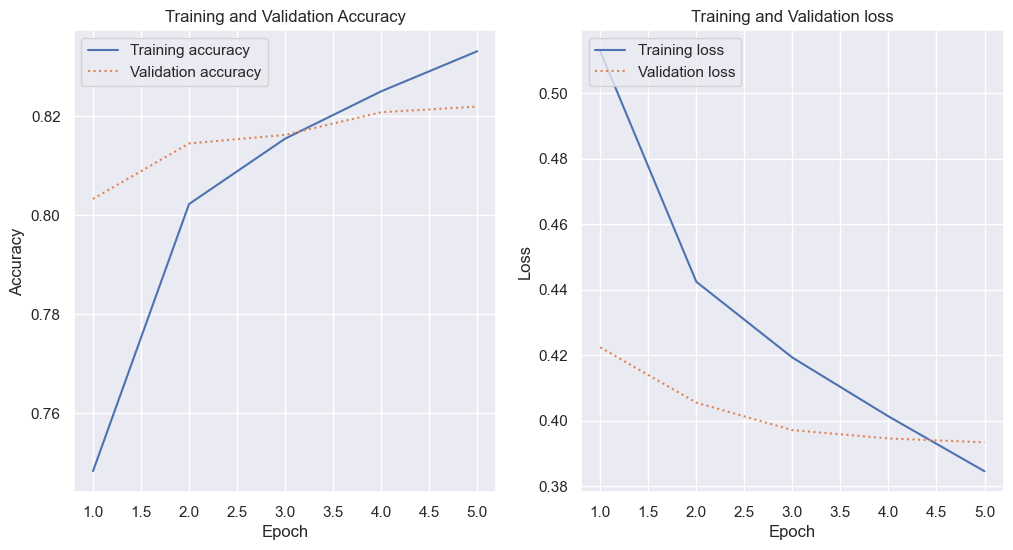

INFO:tensorflow:Assets written to: C:\Users\aurel\AppData\Local\Temp\tmp_5mokdeo\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\aurel\AppData\Local\Temp\tmp_5mokdeo\model\data\model\assets
Successfully registered model 'Keras Glove'.
2023/07/09 22:51:44 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: Keras Glove, version 1


CPU times: total: 17min 26s
Wall time: 27min 35s


Created version '1' of model 'Keras Glove'.


In [33]:
%%time
experiment_name = "Keras simple"
mlflow.set_experiment(experiment_name)
with mlflow.start_run(run_name="Keras Glove"):
    
    batch_size = 256
    
    pipeline = Pipeline([
        ('clean_text', SpacyTextCleaner(lemmatize=True)),
    ])
    
    df_sample_clean = pipeline.transform(df_sample['text'])
    words = [word for sentence in df_sample_clean for word in sentence]
    nb_words = len(set(words))
    X, _ = prepare_keras_data(df_sample_clean, nb_words, max_len)
    X_train, X_valid, X_test, y_train, y_valid, y_test = train_valid_test_split(X, df_sample['target']) 
    
    
    model = Sequential()
    model.add(Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix]))
    model.add(SpatialDropout1D(0.3))
    model.add(Conv1D(128, 5, activation='relu')) 
    model.add(MaxPooling1D(pool_size=4))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(16, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=1)
    
    hist = model.fit(
        X_train, 
        y_train, 
        epochs=5, 
        batch_size=batch_size, 
        validation_data=(X_valid, y_valid), 
        callbacks=[early_stopping], 
        verbose=1
    )

    
    input_example = X_valid[:5]
    output_example = model.predict(input_example)
    signature = infer_signature(input_example, output_example)
    
    y_pred_prob = model.predict(X_test)
    y_pred_bin = (y_pred_prob > 0.5).astype(int)

   
    scores = model.evaluate(X_test, y_test, verbose=0)
    print("Accuracy on test data: %.2f%%" % (scores[1] * 100))
    
    accuracy, precision, recall, f1, score_auc, aucpr_score = calcul_metrics(y_test, y_pred_bin, y_pred_prob, recover=True)
    
    mlflow.log_metrics({
    "accuracy_score": scores[1] * 100,
    "precision_score": precision,
    "recall_score": recall,
    "f1_score": f1,
    "auc": score_auc,
    "precision_recall_score": aucpr_score,
    })
    
    model_name = "Keras_simple_Glove"
    plot_hist(hist, model_name)
    mlflow.log_artifact(f'{model_name}_training_accuracy_loss.png')
    mlflow.keras.log_model(
    model,
    artifact_path="Keras Glove",
    registered_model_name="Keras Glove",
    signature = signature
)

In [19]:
cuda.select_device(0)
cuda.close()
gc.collect()

9644

### Keras simple avec Fasttext

#### Fasttext

In [20]:
fasttext.util.download_model('en', if_exists='ignore')  
ft_model = fasttext.load_model('cc.en.300.bin')
fasttext.util.reduce_model(ft_model, 100)
print(ft_model.get_dimension())

100


In [21]:
def create_embedding_matrix(ft_model):
    vocab_size = len(ft_model.get_words())  
    embedding_dim = ft_model.get_dimension()  
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    for i, word in enumerate(ft_model.get_words()):
        embedding_matrix[i] = ft_model.get_word_vector(word)

    return vocab_size, embedding_dim, embedding_matrix
vocab_size, embedding_dim, embedding_matrix = create_embedding_matrix(ft_model)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         200000000 
                                                                 
 spatial_dropout1d (SpatialD  (None, None, 100)        0         
 ropout1D)                                                       
                                                                 
 conv1d (Conv1D)             (None, None, 128)         64128     
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 128)        0         
 )                                                               
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                        

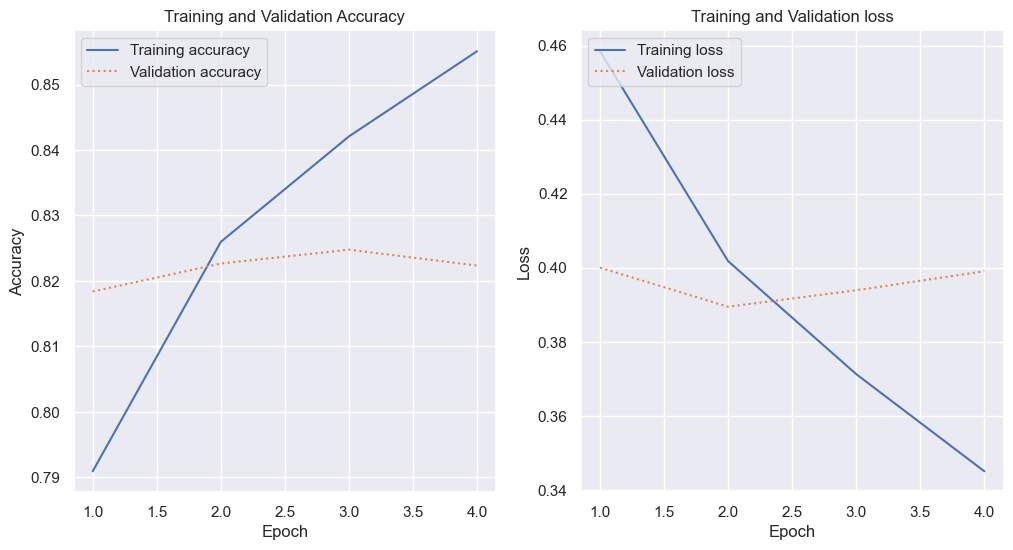

INFO:tensorflow:Assets written to: C:\Users\aurel\AppData\Local\Temp\tmpw_f0incj\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\aurel\AppData\Local\Temp\tmpw_f0incj\model\data\model\assets
C:\Users\aurel\miniconda3\envs\tensorflow\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Registered model 'Keras Fasttext' already exists. Creating a new version of this model...
2023/07/10 01:59:54 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: Keras Fasttext, version 2
Created version '2' of model 'Keras Fasttext'.


CPU times: total: 33min 53s
Wall time: 53min 10s


In [22]:
%%time
experiment_name = "Keras simple"
mlflow.set_experiment(experiment_name)
with mlflow.start_run(run_name="Keras Fasttext"):
    
    batch_size = 128
    
    pipeline = Pipeline([
        ('clean_text', SpacyTextCleaner(lemmatize=True)),
    ])
    
    df_sample_clean = pipeline.transform(df_sample['text'])
    words = [word for sentence in df_sample_clean for word in sentence]
    nb_words = len(set(words))
    X, _ = prepare_keras_data(df_sample_clean, nb_words, max_len)
    X_train, X_valid, X_test, y_train, y_valid, y_test = train_valid_test_split(X, df_sample['target']) 
    
    
    model = Sequential()
    model.add(Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix]))
    model.add(SpatialDropout1D(0.3))
    model.add(Conv1D(128, 5, activation='relu')) 
    model.add(MaxPooling1D(pool_size=4))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(16, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=1)
    
    hist = model.fit(
        X_train, 
        y_train, 
        epochs=5, 
        batch_size=batch_size, 
        validation_data=(X_valid, y_valid), 
        callbacks=[early_stopping], 
        verbose=1
    )

    
    input_example = X_valid[:5]
    output_example = model.predict(input_example)
    signature = infer_signature(input_example, output_example)
    
    y_pred_prob = model.predict(X_test)
    y_pred_bin = (y_pred_prob > 0.5).astype(int)
   
    scores = model.evaluate(X_test, y_test, verbose=0)
    print("Accuracy on test data: %.2f%%" % (scores[1] * 100))
    
    accuracy, precision, recall, f1, score_auc, aucpr_score = calcul_metrics(y_test, y_pred_bin, y_pred_prob, recover=True)
    
    mlflow.log_metrics({
    "accuracy_score": scores[1] * 100,
    "precision_score": precision,
    "recall_score": recall,
    "f1_score": f1,
    "auc": score_auc,
    "precision_recall_score": aucpr_score,
    })
    
    model_name = "Keras_simple_Fasttext"
    plot_hist(hist, model_name)
    mlflow.log_artifact(f'{model_name}_training_accuracy_loss.png')
    mlflow.keras.log_model(
    model,
    artifact_path="Keras Fasttext",
    registered_model_name="Keras Fasttext",
    signature = signature
)

## Modèle Keras avec Embedding pré entrainé Glove + couche LSTM (à déployer)

In [19]:
cuda.select_device(0)
cuda.close()
gc.collect()

9635

In [25]:
vocab_size, embedding_dim, embedding_matrix = create_embedding(glove_model)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         119351500 
                                                                 
 spatial_dropout1d (SpatialD  (None, None, 100)        0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 200)               240800    
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 119,592,501
Trainable params: 119,592,501
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
9375/9375 [==============================] - 1109s 118ms/step - loss: 0.4719 - accuracy: 0.76

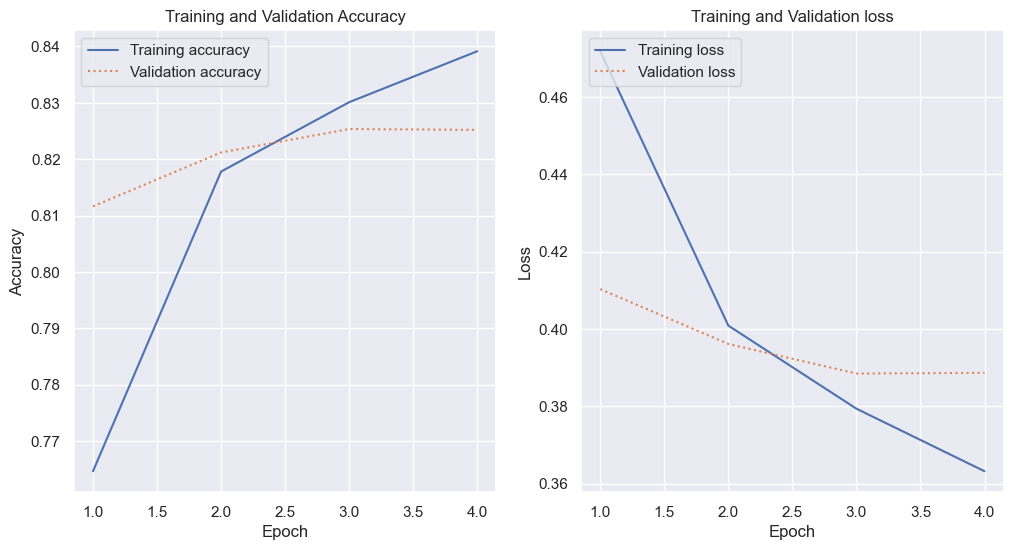

2023/07/10 22:02:06 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\aurel\AppData\Local\Temp\tmpze6b48y3\model\data\model\assets


C:\Users\aurel\miniconda3\envs\tensorflow\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Successfully registered model 'LSTM-Glove'.
2023/07/10 22:02:23 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM-Glove, version 1


CPU times: total: 37min 25s
Wall time: 1h 28min 47s


Created version '1' of model 'LSTM-Glove'.


In [20]:
%%time
experiment_name = "Keras LSTM"
mlflow.set_experiment(experiment_name)
with mlflow.start_run(run_name="LSTM-Glove"):
    
    batch_size = 128
    lstm_out = 200
    
    pipeline = Pipeline([
        ('clean_text', SpacyTextCleaner(lemmatize=True)),
    ])
    
    df_sample_clean = pipeline.transform(df_sample['text'])
    words = [word for sentence in df_sample_clean for word in sentence]
    nb_words = len(set(words))
    X, tokenizer = prepare_keras_data(df_sample_clean, nb_words, max_len)
    X_train, X_valid, X_test, y_train, y_valid, y_test = train_valid_test_split(X, df_sample['target']) 
    
    
    model = Sequential()
    model.add(Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix]))
    model.add(SpatialDropout1D(0.3))
    model.add(LSTM(lstm_out, recurrent_dropout=0.3, dropout=0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=1)
    
    hist = model.fit(
        X_train, 
        y_train, 
        epochs=5, 
        batch_size=batch_size, 
        validation_data=(X_valid, y_valid), 
        callbacks=[early_stopping], 
        verbose=1
    )

    
#     input_example = X_valid[:5]
#     output_example = model.predict(input_example)
#     signature = infer_signature(input_example, output_example)

    y_pred_prob = model.predict(X_test)
    y_pred_bin = (y_pred_prob > 0.5).astype(int)
   
    scores = model.evaluate(X_test, y_test, verbose=0)
    print("Accuracy on test data: %.2f%%" % (scores[1] * 100))
    
    accuracy, precision, recall, f1, score_auc, aucpr_score = calcul_metrics(y_test, y_pred_bin, y_pred_prob, recover=True)
    
    mlflow.log_metrics({
    "accuracy_score": scores[1] * 100,
    "precision_score": precision,
    "recall_score": recall,
    "f1_score": f1,
    "auc": score_auc,
    "precision_recall_score": aucpr_score,
    })
    
    model_name = "LSTM-Glove"
    plot_hist(hist, model_name)
    mlflow.log_artifact(f'{model_name}_training_accuracy_loss.png')
    
    mlflow.keras.log_model(
    model,
    artifact_path="LSTM-Glove",
    registered_model_name="LSTM-Glove",
#     signature = signature
)

#### Sauvegarde du modèle et du Tokenizer

In [21]:
import pickle
with open('tokenizer.pickle', 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
model.save('LSTM_model.h5')

### GridSearch/ Random Search pour optimisation ?

In [ ]:
# def create_model(learning_rate=0.01, batch_size=64):
#     model = Sequential()
#     model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix]))
#     model.add(SpatialDropout1D(0.3))
#     model.add(LSTM(lstm_out, recurrent_dropout=0.3, dropout=0.3))
#     model.add(Dense(1, activation='sigmoid'))
#     optimizer = Adam(lr=learning_rate)
#     model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
#     return model

# model = KerasClassifier(build_fn=create_model, verbose=0)


# param_grid = {
#     'learning_rate': [0.01, 0.1, 0.2],
#     'batch_size': [32, 64, 128],
#     'epochs': [2, 4, 6]
# }

# random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, cv=3)
# random_search_result = random_search.fit(X_train, y_train)

# print("Best: %f using %s" % (random_search_result.best_score_, random_search_result.best_params_))

## BERT - Bidirectional Encoder Representations from Transformers

In [34]:
cuda.select_device(0)
cuda.close()
gc.collect()

14

In [13]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_base = TFBertModel.from_pretrained('bert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [14]:
ADD_DENSE = False
DENSE_DIM = 64
ADD_DROPOUT = True

DROPOUT = .2

def bert_encode(data, maximum_len, batch_size):
    input_ids = []
    attention_masks = []

    for i in range(0, len(data), batch_size):
        batch = data[i:i+batch_size]
        for text in batch:
            encoded = tokenizer.encode_plus(text,
                                            add_special_tokens=True,
                                            padding='max_length',
                                            max_length=maximum_len,
                                            return_attention_mask=True,
                                            truncation=True)
        
            input_ids.append(encoded['input_ids'])
            attention_masks.append(encoded['attention_mask'])

    return np.array(input_ids), np.array(attention_masks)

def build_bert_model(model_layer, learning_rate, add_dense = ADD_DENSE,
               dense_dim = DENSE_DIM, add_dropout = ADD_DROPOUT, dropout = DROPOUT):
    

    input_ids = Input(shape=(40,),dtype='int32')
    attention_masks = Input(shape=(40,),dtype='int32')
    transformer_layer = model_layer([input_ids,attention_masks])
    output = transformer_layer[1]
    
    if add_dense:
        print("Training with additional dense layer...")
        output = Dense(dense_dim,activation='relu')(output)
    
    if add_dropout:
        print("Training with dropout...")
        output = Dropout(dropout)(output)
    
    output = Dense(1,activation='sigmoid')(output)
    model = Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model
BERT_base = build_bert_model(bert_base, learning_rate = 1e-5)
BERT_base.summary()

Training with dropout...
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 40)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 40)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_1[0][0]',                
                                thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 40,                   

Encoding Tweets...
Tweets encoded
Epoch 1/5
18750/18750 [==============================] - 4127s 220ms/step - loss: 0.3556 - accuracy: 0.8428 - val_loss: 0.3305 - val_accuracy: 0.8569
Epoch 2/5
18750/18750 [==============================] - 4185s 223ms/step - loss: 0.3069 - accuracy: 0.8680 - val_loss: 0.3305 - val_accuracy: 0.8603
Epoch 3/5
18750/18750 [==============================] - 4268s 228ms/step - loss: 0.2709 - accuracy: 0.8858 - val_loss: 0.3334 - val_accuracy: 0.8587
Test accuracy with BERT: 85.93%
4688/4688 [==============================] - 231s 49ms/step
              precision    recall  f1-score   support

           0       0.85      0.87      0.86     75000
           1       0.87      0.85      0.86     75000

    accuracy                           0.86    150000
   macro avg       0.86      0.86      0.86    150000
weighted avg       0.86      0.86      0.86    150000

Accuracy score : 0.85928
Precision Score : 0.8690221857025473
Recall Score : 0.84608
F1 Score : 0

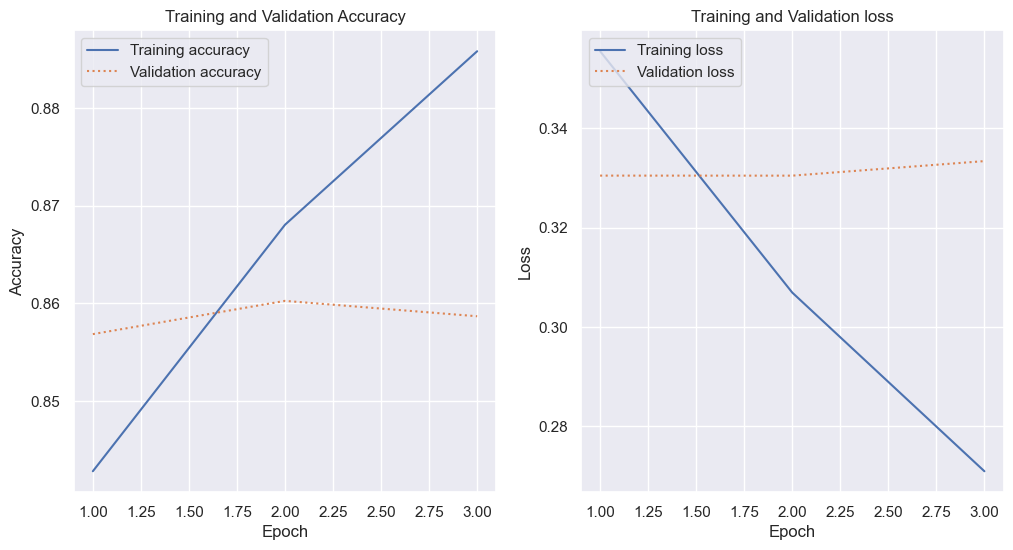

2023/07/11 17:24:17 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\aurel\AppData\Local\Temp\tmp9v0lpk4h\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\aurel\AppData\Local\Temp\tmp9v0lpk4h\model\data\model\assets
2023/07/11 17:25:43 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\aurel\AppData\Local\Temp\tmp9v0lpk4h\model, flavor: tensorflow), fall back to return ['tensorflow==2.10.0']. Set logging level to DEBUG to see the full traceback.
C:\Users\aurel\miniconda3\envs\tensorflow\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Successfully registered model 'BERT-Base-Uncased'.
2023/07/11 17:25:43 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: BERT-Base-Uncased, version 1


CPU times: total: 1h 30min 38s
Wall time: 3h 56min 12s


Created version '1' of model 'BERT-Base-Uncased'.


In [15]:
%%time
experiment_name = "BERT"
mlflow.set_experiment(experiment_name)


with mlflow.start_run(run_name="BERT-Base-Uncased"):
    
    batch_size = 64

    pipeline = Pipeline([
        ('clean_text', SpacyTextCleaner(lemmatize=True, rejoin=True)),
    ])
    
    X = pipeline.transform(df_sample['text'])  
    y = df_sample['target'].values
    
    X_train, X_valid, X_test, y_train, y_valid, y_test = train_valid_test_split(X, y)
    
    print('Encoding Tweets...')
    train_input_ids,train_attention_masks = bert_encode(X_train, max_len, 50_000)
    valid_input_ids,valid_attention_masks = bert_encode(X_valid, max_len, 50_000)
    test_input_ids,test_attention_masks = bert_encode(X_test, max_len, 50_000)
    print('Tweets encoded')

    

    early_stopping = EarlyStopping(monitor='val_accuracy', patience=1)

    hist = BERT_base.fit(
        [train_input_ids,train_attention_masks], 
        y_train, 
        validation_data=([valid_input_ids,valid_attention_masks], y_valid), 
        epochs=5,
        callbacks=[early_stopping],
        verbose=1,
        batch_size=batch_size
    )

    scores = BERT_base.evaluate([test_input_ids, test_attention_masks], y_test, verbose=0)
    print("Test accuracy with BERT: %.2f%%" % (scores[1]*100))

    y_pred_prob = BERT_base.predict([test_input_ids, test_attention_masks])
    y_pred_bin = (y_pred_prob > 0.5).astype(int)
    
    accuracy, precision, recall, f1, score_auc, aucpr_score = calcul_metrics(y_test, y_pred_bin, y_pred_prob, recover=True)
    
    mlflow.log_metrics({
    "accuracy_score": scores[1] * 100,
    "precision_score": precision,
    "recall_score": recall,
    "f1_score": f1,
    "auc": score_auc,
    "precision_recall_score": aucpr_score,
    })
    model_name = "BERT"
    plot_hist(hist, model_name)
    mlflow.log_artifact(f'{model_name}_training_accuracy_loss.png')
    mlflow.keras.log_model(
        BERT_base,
        artifact_path="BERT-Base-Uncased",
        registered_model_name="BERT-Base-Uncased"
    )

## USE - Universel Sentence Encoder

In [ ]:
cuda.select_device(0)
cuda.close()
gc.collect()

In [16]:
embedding = "https://tfhub.dev/google/universal-sentence-encoder/4"
hub_layer = hub.KerasLayer(embedding, input_shape=[], dtype=tf.string, trainable=True)

In [ ]:
%%time
experiment_name = "USE"
mlflow.set_experiment(experiment_name)

with mlflow.start_run(run_name="USE-Base"):
    batch_size = 128
    

    
    pipeline = Pipeline([
        ('clean_text', SpacyTextCleaner(lemmatize=True, rejoin=True)),
    ])
    
    X = pipeline.transform(df_sample['text'])
    X = np.array(X)
    y = df_sample['target'].values
    X_train, X_valid, X_test, y_train, y_valid, y_test = train_valid_test_split(X, y)

    
    model = Sequential()
    model.add(hub_layer)
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='elu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=2)
    

    hist = model.fit(
        X_train, 
        y_train, 
        validation_data=(X_valid, y_valid), 
        epochs=5,
        callbacks=[early_stopping],
        verbose=1, 
        batch_size=batch_size
    )


    y_pred = model.predict(X_test)
    y_pred_bin = (y_pred > 0.5).astype(int)
   
    scores = model.evaluate(X_test, y_test, verbose=0)
    print("Accuracy on test data: %.2f%%" % (scores[1] * 100))
    
    accuracy, precision, recall, f1, score_auc, aucpr_score = calcul_metrics(y_test, y_pred_bin, "Performances sur le test set", recover=True)
    
    mlflow.log_metrics({
    "accuracy_score": scores[1] * 100,
    "precision_score": precision,
    "recall_score": recall,
    "f1_score": f1,
    "auc": score_auc,
    "precision_recall_score": aucpr_score,
    })

    mlflow.log_metrics({
        "test_accuracy_score": scores[1] * 100,
    })
    model_name = "USE"
    plot_hist(hist, model_name)
    mlflow.log_artifact(f'{model_name}_training_accuracy_loss.png')
    mlflow.keras.log_model(
        model,
        artifact_path="USE-Base",
        registered_model_name="USE-Base"
    )
 

2023/07/11 18:21:44 INFO mlflow.tracking.fluent: Experiment with name 'USE' does not exist. Creating a new experiment.
